In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, signal, constants, optimize, signal

In [2]:
with open('rho_1dots_fixed_dt1e-4.csv') as file:
    rho_00_Elliot = []
    for index,line in enumerate(file):
        values = line.split(',')
        rho_00_Elliot.append(np.float(values[0]))
rho_00_Elliot = np.array(rho_00_Elliot)

In [3]:
with open('rho_1dots_fixed_dt1e-4.csv') as file:
    rho_01_real_Elliot = []
    for index,line in enumerate(file):
        values = line.split(',')
        rho_01_real_Elliot.append(np.float(values[1]))
rho_01_real_Elliot = np.array(rho_01_real_Elliot)

In [4]:
with open('rho_1dots_fixed_dt1e-4.csv') as file:
    rho_01_imag_Elliot = []
    for index,line in enumerate(file):
        values = line.split(',')
        rho_01_imag_Elliot.append(np.float(values[2]))
rho_01_imag_Elliot = np.array(rho_01_imag_Elliot)

In [5]:
#Transient Parameters
omega_0 = 2278.9013
stop_time = 10
dt = 1e-4

num_timesteps = np.floor(stop_time / dt).astype(int)

In [6]:
t_elliot = np.linspace(0,stop_time,rho_01_imag_Elliot.size)
rho_01_Elliot = rho_01_real_Elliot + 1j*rho_01_imag_Elliot

In [7]:
#HB parameters
max_harmonic = 4 #Number of harmonics is max_harmonic plus the zero-frequency harmonic (max_harmonic+1)
period = 2*np.pi / omega_0

omega = np.arange(max_harmonic + 1)*omega_0
num_periods = 1

#t = np.linspace(0,num_periods*period,2*max_harmonic + 1)
t = t_elliot[:2*max_harmonic+1]

In [8]:
u_elliot = rho_01_real_Elliot*2
v_elliot = rho_01_imag_Elliot*2
w_elliot = 1-2*rho_00_Elliot

#u_guess = u_elliot[t_elliot<=num_periods*period]
#v_guess = v_elliot[t_elliot<=num_periods*period]
w_guess = w_elliot[t_elliot<=num_periods*period]

u_guess = np.cos(omega_0*t)
v_guess = np.cos(omega_0*t)
#w_guess = np.ones(t.size)/2

In [9]:
#Dot parameters
sigma = 2278.9013
t0 = 1.0
hbar = 0.65821193
T1 = 1e12
T2 = 1e12

In [10]:
def get_chi(t):
    x_hat = np.array([1,0,0])

    d = 5.2917721e-4*x_hat
    E0 = 1558.8929
    
    pulse = np.exp(omega_0*(t - t0)**2/(2*sigma**2))
    
    El = np.array([E0*np.cos(-omega_0*t)*pulse,0,0])
    chi = np.dot(d,El) / hbar
    return chi

In [11]:
def idft(V):
    V_full = np.zeros(2*V.size - 1,dtype=np.complex)
    V_full[:V.size] = V
    V_full[V.size:]=np.flip(V[1:].conj())
    v_t = np.fft.ifft(V_full)
    return v_t

In [12]:
def dft(v_t):
    V = np.fft.fft(v_t)
    return V[:max_harmonic + 1]

In [13]:
def get_y_dot(y,t):
    #Returns the finite difference approximation of the time derivative of y, assuming a constant sampling interval
    dy = y[2:] - y[:-2]
    dt = (t[-1] - t[0])/t.size
    
    y_dot = dy/dt
    
    y_dot_initial = y_dot[0]
    y_dot_final = y_dot[-1]
    y_dot = np.hstack((y_dot_initial,y_dot,y_dot_final))
   
    return y_dot

In [14]:
def check_error_functions(u,v,w,t):
    U = dft(u)
    V = dft(v)
    W = dft(w)
    
    chi = get_chi(t_elliot)
    
    fu_t = -omega_0*v - u/T2 - get_y_dot(u,t)
    fv_t = omega_0*u - 2*get_chi(t)*w - v/T2 - get_y_dot(v,t)
    fw_t = 2*get_chi(t)*v - (w+1)/T1 - get_y_dot(w,t)
    
    print('Error function 1 average error:',np.mean(abs(fu_t)))
    print('Error function 2 average error:',np.mean(abs(fv_t)))
    print('Error function 3 average error:',np.mean(abs(fw_t)))
    print('\n')
    print('Error function 1 max error:',np.max(abs(fu_t)))
    print('Error function 2 max error:',np.max(abs(fv_t)))
    print('Error function 3 max error:',np.max(abs(fw_t)))
    
    plt.figure()
    plt.semilogy(t,abs(fu_t),label='fu_t error')
    plt.semilogy(t,abs(fv_t),label='fv_t error')
    plt.semilogy(t,abs(fw_t),label='fw_t error')
    plt.xlabel('time')
    plt.legend()
    plt.show()
    
    Fu = -omega_0*V - U/T2 - 1j*omega*U
    Fv = omega_0*U - dft(2*chi*w) - V/T2 - 1j*omega*V
    Fw = dft(2*chi*v) - (W+1)/T1 - 1j*omega*W
    
    print('Error function 1 average harmonic error:',np.mean(abs(Fu)))
    print('Error function 2 average harmonic error:',np.mean(abs(Fv)))
    print('Error function 3 average harmonic error:',np.mean(abs(Fw)))
    
    print('\n')
    print('Error function 1 max harmonic error:',np.max(abs(Fu)))
    print('Error function 2 max harmonic error:',np.max(abs(Fv)))
    print('Error function 3 max harmonic error:',np.max(abs(Fw)))
    
    plt.figure()
    plt.semilogy(abs(Fu),label='F_u harmonic error')
    plt.semilogy(abs(Fv),label='F_v harmonic error')
    plt.semilogy(abs(Fw),label='F_w harmonic error')
    plt.xlabel('Harmonic')
    plt.legend()
    plt.show()

Error function 1 average error: 774.3781265090468
Error function 2 average error: 773.4107747519013
Error function 3 average error: 0.7356427497263721


Error function 1 max error: 2239.406140653761
Error function 2 max error: 2239.52520645033
Error function 3 max error: 5.658416295568634


/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


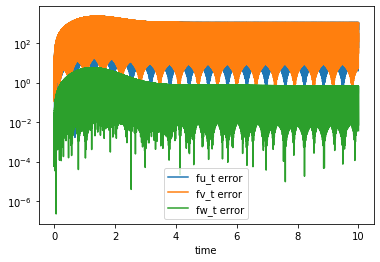

Error function 1 average harmonic error: 4920.478629721954
Error function 2 average harmonic error: 9635.599974163346
Error function 3 average harmonic error: 66458323.680459045


Error function 1 max harmonic error: 5181.69031835169
Error function 2 max harmonic error: 19045.579828425827
Error function 3 max harmonic error: 97128803.85706238


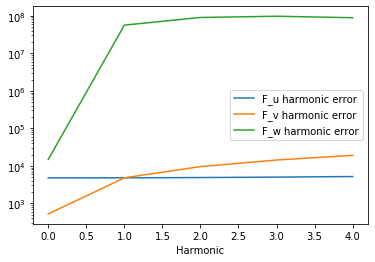

In [15]:
check_error_functions(u_elliot,v_elliot,w_elliot,t_elliot)

In [16]:
def get_fu(U,V,W):
    return -omega_0*V - U/T2 - 1j*omega*U

In [17]:
def get_fv(U,V,W):
    w = idft(W)
    chi = get_chi(t)
    return omega_0*U - dft(2*chi*w) - V/T2 - 1j*omega*V

In [18]:
def get_fw(U,V,W):
    v = idft(V)
    chi = get_chi(t)
    return dft(2*chi*v) - (W+1)/T1 - 1j*omega*W

In [19]:
def get_dfu_du(U,V,W):
    dfu_du = (-1/T2 - 1j*omega)*np.ones(U.size)
    dfu_du = np.diag(dfu_du)
    return dfu_du

In [20]:
def get_dfu_dv(U,V,W):
    dfu_dv = np.ones(U.size)*-omega_0
    dfu_dv = np.diag(dfu_dv)
    return dfu_dv

In [21]:
def get_dfu_dw(U,V,W):
    dfu_dw = np.zeros(U.size)
    dfu_dw = np.diag(dfu_dw)
    return dfu_dw

In [22]:
def get_dfv_du(U,V,W):
    dfv_du = omega_0*np.ones(U.size)
    dfv_du = np.diag(dfv_du)
    return dfv_du

In [23]:
def get_dfv_dv(U,V,w):
    dfv_dv = (-1/T2 - 1j*omega)*np.ones(U.size)
    dfv_dv = np.diag(dfv_dv)
    return dfv_dv

In [24]:
def get_dfv_dw(U,V,W):
    n = 2*U.size - 1
    DFT = linalg.dft(n)
    IDFT = np.conj(DFT.T)/(n)
    
    chi = get_chi(t)
    dfv_dw = DFT@(np.diag(-2*chi)@IDFT)
    
    return dfv_dw[:U.size,:U.size]

In [25]:
def get_dfw_du(U,V,W):
    dfw_du = np.zeros(U.size)
    dfw_du = np.diag(dfw_du)
    return dfw_du

In [26]:
def get_dfw_dv(U,V,W):
    n = 2*U.size - 1
    DFT = linalg.dft(n)
    IDFT = np.conj(DFT.T)/(n)
    
    chi = get_chi(t)
    
    dfw_dv = DFT@(np.diag(2*chi)@IDFT)
    
    return dfw_dv[:U.size,:U.size]

In [27]:
def get_dfw_dw(U,V,W):
    dfw_dw = -1/T1 - 1j*omega * np.ones(U.size)
    dfw_dw = np.diag(dfw_dw)
    return dfw_dw

In [28]:
def get_Jacobian(U,V,W):
    dfu_du = get_dfu_du(U,V,W)
    dfu_dv = get_dfu_dv(U,V,W)
    dfu_dw = get_dfu_dw(U,V,W)
    
    dfv_du = get_dfv_du(U,V,W)
    dfv_dv = get_dfv_dv(U,V,W)
    dfv_dw = get_dfv_dw(U,V,W)
    
    dfw_du = get_dfw_du(U,V,W)
    dfw_dv = get_dfw_dv(U,V,W)
    dfw_dw = get_dfw_dw(U,V,W)
    
    grad_fu = np.hstack((dfu_du,dfu_dv,dfu_dw))
    grad_fv = np.hstack((dfv_du,dfv_dv,dfv_dw))
    grad_fw = np.hstack((dfw_du,dfw_dv,dfw_dw))
    
    Jacobian = np.vstack((grad_fu,grad_fv,grad_fw))

    return Jacobian

In [29]:
def Harmonic_Balance_Solution(u_guess,v_guess,w_guess):
    epsilon = 1e-2
    max_iterations = 100000
    
    u = u_guess
    v = v_guess
    w = w_guess
    
    U = dft(u)
    V = dft(v)
    W = dft(w)
    
    for iteration in range(max_iterations):
        #print('iteration:',iteration)
        f_u = get_fu(U,V,W)
        f_v = get_fv(U,V,W)
        f_w = get_fw(U,V,W)
        fk = np.hstack((f_u,f_v,f_w))
        print('fk:',abs(fk))
        
        UVW = np.hstack((U,V,W))
        
        if (abs(fk)<epsilon).all():
            print('Converged after', iteration, 'iterations')
            return u,v,w
        
        Jacobian = get_Jacobian(U,V,W)
        
        delta_UVW = linalg.solve(Jacobian,fk)
        UVW -= delta_UVW
        
        U = UVW[:(max_harmonic+1)]
        V = UVW[(max_harmonic+1):2*(max_harmonic+1)]
        W = UVW[2*(max_harmonic+1):]

        u = idft(U)
        v = idft(V)
        w = idft(W)
        
        #print('delta_UVW:',abs(delta_UVW))
        #if (abs(delta_UVW)<epsilon).all():
         #   print('Converged after', iteration, 'iterations')
          #  return u,v,w

    print('Exceeded max iterations.')

In [30]:
u,v,w = Harmonic_Balance_Solution(u_guess,v_guess,w_guess)

fk: [1.04962200e+04 7.32126188e+03 5.52554326e+03 5.69284187e+03
 6.49372876e+03 1.05321453e+04 7.33380176e+03 5.52933087e+03
 5.69479335e+03 6.49503828e+03 1.00534513e+01 5.53116890e+00
 1.88108112e+00 1.31355706e+00 1.14247232e+00]
fk: [2.04932156e-19 9.09494702e-13 1.01203529e-12 4.00042074e-13
 1.01203552e-12 1.38745257e-03 7.22042872e-04 5.61957227e-04
 5.29310558e-04 6.09444950e-04 4.14397199e+00 2.19729370e+00
 1.73105776e+00 1.65681712e+00 1.98053463e+00]
fk: [5.82275386e-34 9.09494702e-13 4.84869952e-19 0.00000000e+00
 0.00000000e+00 2.71160957e-03 1.39306628e-03 1.07382622e-03
 1.00038616e-03 1.12666472e-03 4.14397199e+00 1.97804338e+00
 1.44103631e+00 1.26071074e+00 1.26071053e+00]
fk: [3.86600879e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 6.77626358e-21 2.65344246e-03 1.34669961e-03 1.02829519e-03
 9.47277096e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071072e+00 1.26071050e+00]
fk: [1.94301772e-34 9.09494702e-13 3.06658683e-19 2.16840434e-19

fk: [1.15620181e-33 2.73085155e-12 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15555811e-33 1.83314518e-12 3.06658683e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15651058e-33 9.09494702e-13 4.84869952e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15681007e-33 9.09494702e-13 3.06658683e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.18199498e-37 9.16572588e-13 3.06658683e-19 1.95457326e-19

fk: [1.60633599e-35 9.09494702e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93172674e-34 9.09494702e-13 2.42434976e-19 1.62630326e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [6.52883797e-35 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [4.38996631e-36 9.09494702e-13 2.16840434e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86429496e-34 3.63797881e-12 3.06658683e-19 1.08420217e-19

fk: [3.85186247e-34 2.72848411e-12 3.06658683e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.35979671e-35 3.63797881e-12 6.85709662e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85203136e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87354370e-34 9.09494702e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86490013e-34 9.37485680e-13 3.06658683e-19 3.25260652e-19

fk: [9.62965441e-34 1.81898940e-12 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85312416e-34 2.72848411e-12 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.06586474e-35 1.81898940e-12 2.42434976e-19 2.16840434e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77873418e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.87663541e-36 9.09494702e-13 8.94056015e-19 1.21217488e-19

fk: [2.23047298e-35 9.09494702e-13 2.42434976e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92749369e-34 9.09494702e-13 2.42434976e-19 3.25260652e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.84124922e-37 9.37485680e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97067573e-34 2.72848411e-12 2.42434976e-19 2.23514004e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.94515190e-34 9.09494702e-13 8.94056015e-19 0.00000000e+00

fk: [9.62968888e-34 2.72848411e-12 2.42434976e-19 2.23514004e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92636001e-34 9.09494702e-13 2.42434976e-19 1.53329342e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.71156294e-34 9.09494702e-13 2.16840434e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85220813e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [6.59765260e-35 2.72848411e-12 3.06658683e-19 1.21217488e-19

fk: [5.77782118e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85783067e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85186018e-34 9.71340767e-13 2.16840434e-19 3.42854831e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.71030073e-34 9.71340767e-13 3.06658683e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.89072117e-34 9.71340767e-13 2.42434976e-19 1.08420217e-19

fk: [9.68963462e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.82060118e-34 9.09494702e-13 2.42434976e-19 1.95457326e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.73937642e-35 9.09494702e-13 2.42434976e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.66422581e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.06236744e-35 9.09494702e-13 2.16840434e-19 1.53329342e-19

fk: [3.96732429e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15610824e-33 2.72848411e-12 2.16840434e-19 0.00000000e+00
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85224261e-34 9.09494702e-13 3.06658683e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85295604e-34 1.83314518e-12 3.06658683e-19 1.08420217e-19
 2.03287907e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.90355979e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20

fk: [5.77819138e-34 9.37485680e-13 3.06658683e-19 1.95457326e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79140833e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.72702709e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93003231e-34 9.37485680e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78184003e-34 9.71340767e-13 4.84869952e-19 1.53329342e-19

fk: [3.85411335e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.85036280e-34 9.09494702e-13 2.16840434e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.63785324e-34 9.09494702e-13 6.85709662e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97712707e-34 9.09494702e-13 3.06658683e-19 2.42434976e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85261038e-34 2.72848411e-12 2.42434976e-19 1.21217488e-19

fk: [2.22032398e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70634241e-34 1.81898940e-12 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.33566824e-35 9.09494702e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.94613879e-34 2.72848411e-12 2.42434976e-19 2.23514004e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.36024113e-36 1.81898940e-12 2.16840434e-19 2.71050543e-19

fk: [3.85221316e-34 9.09494702e-13 2.42434976e-19 3.25260652e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97670149e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.72228029e-34 9.09494702e-13 4.47028008e-19 5.42101086e-20
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.54075239e-33 1.81898940e-12 3.06658683e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96529472e-34 9.71340767e-13 3.06658683e-19 1.21217488e-19

fk: [1.92704192e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70928561e-34 2.74971776e-12 4.47028008e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93689424e-34 9.37485680e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.04790036e-34 9.09494702e-13 4.47028008e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.95136684e-34 9.37485680e-13 4.33680869e-19 1.08420217e-19

 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70449376e-34 9.71340767e-13 2.42434976e-19 2.16840434e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.82422934e-34 9.71340767e-13 2.42434976e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.64631565e-34 9.71340767e-13 2.16840434e-19 0.00000000e+00
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.18638180e-34 9.09494702e-13 6.85709662e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.02684993e-

fk: [7.70373082e-34 9.71340767e-13 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93715526e-34 3.64507731e-12 2.16840434e-19 3.42854831e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93153805e-34 2.72848411e-12 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.63754000e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78024792e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19

fk: [1.15723335e-33 9.09494702e-13 6.85709662e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.30615198e-35 9.37485680e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93025586e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92952347e-35 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93524938e-34 1.81898940e-12 6.59494435e-19 2.16840434e-19

fk: [1.93201083e-34 9.37485680e-13 4.84869952e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.66708779e-35 2.72848411e-12 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15581885e-33 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93057274e-34 1.81898940e-12 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15562776e-33 9.09494702e-13 2.42434976e-19 5.42101086e-20

fk: [5.78757078e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.89259761e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79226091e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.69785727e-35 9.16572588e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.90244568e-34 9.37485680e-13 2.42434976e-19 2.23514004e-19

fk: [5.78258941e-34 9.09494702e-13 6.85709662e-19 2.16840434e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78328202e-34 9.09494702e-13 3.06658683e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78254450e-34 9.37485680e-13 2.42434976e-19 3.29747218e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70372086e-34 9.09494702e-13 6.59494435e-19 2.42434976e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93888647e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19

fk: [3.85370329e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.88163241e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86368967e-34 9.71340767e-13 2.42434976e-19 3.29747218e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85475777e-34 9.09494702e-13 2.42434976e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.72994140e-34 9.09494702e-13 3.06658683e-19 2.23514004e-19

fk: [6.10094425e-35 9.09494702e-13 3.06658683e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.11872421e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.90422933e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93318039e-34 2.72848411e-12 2.42434976e-19 3.63652464e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [4.19466205e-35 9.71340767e-13 2.42434976e-19 1.21217488e-19

fk: [1.99106606e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.82302328e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.99791763e-34 3.63975473e-12 3.06658683e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.33664728e-35 9.37485680e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70372044e-34 1.81898940e-12 3.06658683e-19 1.53329342e-19

fk: [1.93220850e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.92892778e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70984147e-34 9.37485680e-13 3.06658683e-19 1.08420217e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.66806571e-34 9.09494702e-13 3.06658683e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96999418e-34 9.09494702e-13 2.42434976e-19 2.16840434e-19

fk: [3.88124557e-34 2.72848411e-12 2.42434976e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.95694460e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87427892e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77819796e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70381046e-34 9.09494702e-13 4.47028008e-19 1.08420217e-19

fk: [3.91221017e-34 2.73794162e-12 2.42434976e-19 1.21217488e-19
 2.03287907e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.55309303e-35 9.09494702e-13 2.42434976e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92626059e-34 9.09494702e-13 3.06658683e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.99122032e-34 3.63797881e-12 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97962995e-34 9.37485680e-13 6.59494435e-19 1.08420217e-19

fk: [3.90053891e-34 9.09494702e-13 2.42434976e-19 2.16840434e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.63003009e-34 2.73794162e-12 8.74111737e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97969078e-34 2.72848411e-12 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85937551e-34 9.09494702e-13 2.16840434e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.71602613e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20

fk: [1.94267571e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.01152922e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.97335742e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.40627007e-35 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.32515701e-35 9.09494702e-13 2.42434976e-19 5.42101086e-20

fk: [3.87167016e-34 9.37485680e-13 2.42434976e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85211911e-34 9.37485680e-13 2.42434976e-19 2.16840434e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.89963967e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.05306239e-34 3.63797881e-12 2.42434976e-19 1.08420217e-19
 2.03287907e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.80119953e-34 9.37485680e-13 2.42434976e-19 1.08420217e-19

fk: [3.85304456e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70690555e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77898183e-34 1.81898940e-12 2.42434976e-19 2.23514004e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.02964023e-35 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.98494224e-35 3.64507731e-12 2.16840434e-19 1.53329342e-19

fk: [5.79110277e-34 2.72848411e-12 6.59494435e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.71347504e-34 3.63797881e-12 8.74111737e-19 3.29747218e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.08282905e-35 9.09494702e-13 6.59494435e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85665692e-35 9.09494702e-13 2.42434976e-19 4.47028008e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70609787e-34 9.37485680e-13 2.42434976e-19 2.16840434e-19

fk: [3.87604263e-34 9.09494702e-13 3.06658683e-19 5.42101086e-20
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.94827400e-34 9.09494702e-13 6.59494435e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85659384e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79727533e-34 2.72848411e-12 2.16840434e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87654484e-34 3.64507731e-12 3.06658683e-19 1.08420217e-19

fk: [1.15557045e-33 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.06054997e-34 9.09494702e-13 4.47028008e-19 2.16840434e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70896883e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86157152e-34 3.63797881e-12 2.42434976e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.75128356e-35 9.09494702e-13 4.47028008e-19 1.21217488e-19

fk: [3.85249200e-34 1.83314518e-12 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [8.01438732e-35 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86361996e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.04502038e-35 3.63797881e-12 3.06658683e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.80443839e-34 9.09494702e-13 3.06658683e-19 2.23514004e-19

fk: [1.98155221e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.05858098e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.65533719e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.00078675e-34 1.81898940e-12 2.16840434e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.82242659e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19

fk: [1.17042962e-35 9.09494702e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.95488358e-34 9.37485680e-13 2.42434976e-19 1.21217488e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.71354879e-34 9.16572588e-13 6.59494435e-19 3.25260652e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70902993e-34 9.37485680e-13 4.47028008e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.75596344e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19

fk: [5.77782253e-34 9.09494702e-13 2.42434976e-19 2.42434976e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92601506e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.15246987e-36 9.09494702e-13 3.06658683e-19 1.21217488e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92802124e-34 9.09494702e-13 2.42434976e-19 2.42434976e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85307859e-34 9.71340767e-13 2.42434976e-19 1.08420217e-19

fk: [3.86318533e-34 9.37485680e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.62967004e-34 9.16572588e-13 8.94056015e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85252783e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77942601e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87088048e-34 9.09494702e-13 2.42434976e-19 2.16840434e-19

fk: [7.70411646e-34 9.16572588e-13 2.42434976e-19 1.21217488e-19
 1.08631769e-19 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92745179e-34 2.74971776e-12 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85242818e-34 9.09494702e-13 6.59494435e-19 3.29747218e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86243393e-34 2.73794162e-12 4.47028008e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86861022e-34 9.09494702e-13 3.06658683e-19 1.21217488e-19

fk: [4.90001147e-35 9.09494702e-13 2.42434976e-19 2.16840434e-19
 1.08631769e-19 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.81416444e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87851888e-34 9.16572588e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96591776e-34 9.37485680e-13 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85430586e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19

fk: [3.89822287e-34 9.37485680e-13 3.06658683e-19 0.00000000e+00
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.72377638e-34 9.09494702e-13 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.89428663e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86870888e-34 9.71340767e-13 2.16840434e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.98658716e-34 9.37485680e-13 3.06658683e-19 1.08420217e-19

fk: [7.74634661e-34 1.81898940e-12 6.59494435e-19 4.37055868e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93934298e-35 9.09494702e-13 2.42434976e-19 1.95457326e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86027846e-34 9.71340767e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87327436e-34 9.37485680e-13 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87786063e-34 9.71340767e-13 8.74111737e-19 0.00000000e+00

fk: [5.78497166e-34 3.63797881e-12 3.06658683e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92621026e-34 2.72848411e-12 2.42434976e-19 1.95457326e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79241592e-34 2.72848411e-12 2.42434976e-19 3.63652464e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.65944750e-34 9.37485680e-13 2.42434976e-19 2.42434976e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70772191e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19

fk: [3.87736664e-34 3.64507731e-12 2.42434976e-19 1.53329342e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.15859570e-33 1.81898940e-12 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.88675689e-34 9.09494702e-13 2.42434976e-19 2.16840434e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [8.58542044e-35 1.81898940e-12 2.42434976e-19 1.08420217e-19
 2.03287907e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [4.59061768e-35 9.37485680e-13 2.42434976e-19 5.42101086e-20

fk: [9.69102540e-34 9.09494702e-13 6.85709662e-19 3.25260652e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92609612e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.63020113e-34 9.09494702e-13 3.06658683e-19 3.25260652e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70372527e-34 9.09494702e-13 3.06658683e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.13977624e-35 3.63797881e-12 2.16840434e-19 2.16840434e-19

fk: [5.77801485e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.83053973e-34 1.81898940e-12 3.06658683e-19 1.53329342e-19
 2.03287907e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.00847672e-35 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93045075e-34 9.09494702e-13 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78578042e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19

fk: [4.46742266e-35 9.09494702e-13 2.42434976e-19 1.53329342e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.86819018e-34 9.09494702e-13 2.42434976e-19 4.47028008e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.90112041e-34 9.16572588e-13 3.06658683e-19 3.42854831e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.63743361e-34 1.87497136e-12 3.06658683e-19 1.21217488e-19
 2.03287907e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [8.13539207e-35 9.09494702e-13 2.42434976e-19 2.23514004e-19

fk: [3.85206639e-34 9.09494702e-13 2.16840434e-19 1.62630326e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78116459e-34 2.72848411e-12 2.42434976e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.72908000e-34 1.81898940e-12 2.16840434e-19 2.16840434e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.08819782e-35 9.09494702e-13 3.06658683e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96104992e-34 1.81898940e-12 2.42434976e-19 2.42434976e-19

fk: [9.63492478e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92592994e-34 9.09494702e-13 3.06658683e-19 4.33680869e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79501031e-34 9.16572588e-13 3.06658683e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85187474e-34 9.71340767e-13 6.59494435e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79479048e-34 1.83314518e-12 2.42434976e-19 1.95457326e-19

fk: [3.85425575e-34 9.09494702e-13 3.06658683e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.85354791e-34 3.63797881e-12 2.42434976e-19 1.08420217e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.98583357e-34 1.83314518e-12 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.93660278e-34 2.74971776e-12 2.42434976e-19 1.53329342e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78276083e-34 2.74971776e-12 3.06658683e-19 1.08420217e-19

fk: [3.85186087e-34 9.09494702e-13 3.06658683e-19 0.00000000e+00
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93366601e-34 9.09494702e-13 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.69725148e-35 9.09494702e-13 3.06658683e-19 2.71050543e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.64176476e-34 9.16572588e-13 2.42434976e-19 2.16840434e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.51410854e-35 9.09494702e-13 2.42434976e-19 2.16840434e-19

fk: [1.92688182e-34 9.37485680e-13 3.06658683e-19 0.00000000e+00
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [7.70906110e-34 9.09494702e-13 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96964352e-34 9.37485680e-13 4.47028008e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.93382705e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77937726e-34 9.37485680e-13 6.59494435e-19 1.21217488e-19

fk: [1.99415701e-34 1.81898940e-12 8.94056015e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.92439321e-34 2.72848411e-12 3.06658683e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.02206242e-34 9.09494702e-13 3.06658683e-19 1.53329342e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.80273569e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.93686240e-34 9.09494702e-13 2.42434976e-19 3.63652464e-19

fk: [1.15575890e-33 9.09494702e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.16589525e-35 9.09494702e-13 4.47028008e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.98419584e-34 1.81898940e-12 2.42434976e-19 2.42434976e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92759176e-34 2.72848411e-12 2.16840434e-19 2.23514004e-19
 0.00000000e+00 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.98393031e-34 1.81898940e-12 3.06658683e-19 1.08420217e-19

fk: [9.64630407e-34 9.37485680e-13 2.42434976e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [2.01600991e-34 1.81898940e-12 2.42434976e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.93042410e-34 9.09494702e-13 6.59494435e-19 0.00000000e+00
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.96316926e-34 2.74971776e-12 2.42434976e-19 1.08420217e-19
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.79636333e-34 9.09494702e-13 2.42434976e-19 0.00000000e+00

fk: [3.86405205e-34 9.09494702e-13 3.06658683e-19 2.23514004e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.87281791e-34 3.63797881e-12 3.06658683e-19 5.42101086e-20
 6.77626358e-21 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [3.94301808e-34 2.73794162e-12 2.42434976e-19 1.08420217e-19
 1.35525272e-20 2.65344245e-03 1.34669960e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.78340236e-34 9.09494702e-13 6.85709662e-19 1.21217488e-19
 6.77626358e-21 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [4.30065629e-36 9.09494702e-13 2.42434976e-19 5.42101086e-20

fk: [7.70614374e-34 9.37485680e-13 3.06658683e-19 1.95457326e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.92632241e-34 9.09494702e-13 2.42434976e-19 1.21217488e-19
 1.35525272e-20 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [9.44838712e-35 9.09494702e-13 6.59494435e-19 2.71050543e-19
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [5.77780639e-34 9.09494702e-13 4.33680869e-19 5.42101086e-20
 0.00000000e+00 2.65344245e-03 1.34669961e-03 1.02829519e-03
 9.47277092e-04 1.04183613e-03 4.14397199e+00 1.97804337e+00
 1.44103630e+00 1.26071073e+00 1.26071051e+00]
fk: [1.98549416e-34 9.71340767e-13 3.06658683e-19 1.08420217e-19

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(t[:2*max_harmonic],u.real[:2*max_harmonic],label='u Chad')
plt.plot(t[:2*max_harmonic],u_guess.real[:2*max_harmonic],label='u_Elliot')
plt.xlabel('time')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t[:2*max_harmonic],v.real[:2*max_harmonic],label='v Chad')
plt.plot(t[:2*max_harmonic],v_guess.real,label='v_Elliot')
plt.xlabel('time')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t[:2*max_harmonic],w.real[:2*max_harmonic],label='w Chad')
plt.plot(t[:2*max_harmonic],w_guess.real,label='w_Elliot')
plt.xlabel('time')
plt.legend()
plt.show()

In [ ]:
rho_00 = (1-w)/2
rho_01 = 0.5*u + 1j*0.5*v

rho_01_real = 0.5*u
rho_01_imag = 1j*0.5*v

In [ ]:
plt.figure()
plt.plot(t,rho_01_real_Elliot[:t.size],label='rho_01 Real Elliot')
plt.plot(t,rho_01.real,label='rho_01 Real Chad')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t,rho_01.imag,label='rho_01 imaginary Chad')
plt.plot(t,rho_01_imag_Elliot[:t.size],label='rho_01 imaginary Elliot')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t,rho_00.real,label='rho_00 Chad')
plt.plot(t,rho_00_Elliot[:t.size],label='rho_00 Elliot')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t_elliot,rho_00_Elliot,label='rho_00 Elliot')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t_elliot,rho_01_imag_Elliot,label='rho_01 Imaginary Elliot')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t_elliot,abs(rho_01_Elliot),label='rho_01 Magnitude Elliot')
plt.legend()
plt.show()